# Proyecto de Consultoría a Hyundai Heavy
## Laboratorio 10

In [18]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, count as count_func, when, isnan, corr, max as spark_max, min as spark_min, mean
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Iniciar sesión de Spark

In [2]:
spark = SparkSession.builder.appName("Lab Spark RL — Hyundai Heavy").getOrCreate()
print("Spark version:", spark.version)

Spark version: 3.5.0


### Carga del archivo CSV

In [3]:
df_hyundai = spark.read.csv(
    'barcos_crucero.csv',
    header=True,
    inferSchema=True
)

## Análisis de los datos

In [4]:
# Contar registros
total_registros = df_hyundai.count()
print(f"Total de barcos en el dataset: {total_registros}")

Total de barcos en el dataset: 158


In [5]:
df_hyundai.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [6]:
df_hyundai.describe().show()

+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|summary|Ship_name|Cruise_line|               Age|           Tonnage|       passengers|           length|            cabins|passenger_density|             crew|
+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|  count|      158|        158|               158|               158|              158|              158|               158|              158|              158|
|   mean| Infinity|       NULL|15.689873417721518| 71.28467088607599|18.45740506329114|8.130632911392404| 8.830000000000005|39.90094936708861|7.794177215189873|
| stddev|     NULL|       NULL| 7.615691058751413|37.229540025907866|9.677094775143416|1.793473548054825|4.4714172221480615| 8.63921711391542|3.503486564627034|
|    min|Adventure|    Azamara|   

In [7]:
# Verificar valores nulos
print("\n Análisis de Valores Nulos:")
df_hyundai.select([count(when(col(c).isNull() | isnan(c), c)).alias(c)
                   for c in df_hyundai.columns]).show()


 Análisis de Valores Nulos:
+---------+-----------+---+-------+----------+------+------+-----------------+----+
|Ship_name|Cruise_line|Age|Tonnage|passengers|length|cabins|passenger_density|crew|
+---------+-----------+---+-------+----------+------+------+-----------------+----+
|        0|          0|  0|      0|         0|     0|     0|                0|   0|
+---------+-----------+---+-------+----------+------+------+-----------------+----+



In [8]:
# Verificar duplicados por nombre de barco
print("\n Verificación de Duplicados:")
duplicados = df_hyundai.groupBy("Ship_name").count().filter(col("count") > 1)
duplicate_count = duplicados.count()
print(f"Barcos con nombres duplicados: {duplicate_count}")
if duplicate_count > 0:
    duplicados.show()


 Verificación de Duplicados:
Barcos con nombres duplicados: 16
+---------+-----+
|Ship_name|count|
+---------+-----+
|     Wind|    2|
|  Majesty|    2|
|   Spirit|    4|
|     Dawn|    2|
|      Sun|    2|
|Navigator|    2|
|    Pride|    2|
|      Sea|    2|
| Rhapsody|    2|
|  Mariner|    2|
|  Freedom|    2|
|    Crown|    2|
|   Legend|    3|
|     Star|    3|
|    Jewel|    2|
|  Voyager|    2|
+---------+-----+



In [9]:
print("\nANÁLISIS DE LA VARIABLE OBJETIVO: CREW")
print("-" * 80)

crew_stats = df_hyundai.select("crew").describe()
crew_stats.show()

# Convertir a Pandas para visualización
crew_pandas = df_hyundai.select("crew").toPandas()
print(f"Rango de tripulación: {crew_pandas['crew'].min():.2f} - {crew_pandas['crew'].max():.2f} (en 100s)")
print(f"Mediana de tripulación: {crew_pandas['crew'].median():.2f} (en 100s)")


ANÁLISIS DE LA VARIABLE OBJETIVO: CREW
--------------------------------------------------------------------------------
+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|              158|
|   mean|7.794177215189873|
| stddev|3.503486564627034|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+

Rango de tripulación: 0.59 - 21.00 (en 100s)
Mediana de tripulación: 8.15 (en 100s)


In [10]:
print("\n MATRIZ DE CORRELACIÓN")
print("-" * 80)

# Seleccionar solo variables numéricas (excluir Ship_name y Cruise_line)
numeric_cols = ["Age", "Tonnage", "passengers", "length", "cabins",
                "passenger_density", "crew"]

# Convertir a Pandas para análisis de correlación más fácil
df_pandas = df_hyundai.select(numeric_cols).toPandas()

# Matriz de correlación
correlation_matrix = df_pandas.corr()
print("\nMatriz de Correlación con CREW (Variable Objetivo):")
crew_correlations = correlation_matrix["crew"].sort_values(ascending=False)
print(crew_correlations)


 MATRIZ DE CORRELACIÓN
--------------------------------------------------------------------------------

Matriz de Correlación con CREW (Variable Objetivo):
crew                 1.000000
cabins               0.950823
Tonnage              0.927569
passengers           0.915234
length               0.895857
passenger_density   -0.155509
Age                 -0.530657
Name: crew, dtype: float64


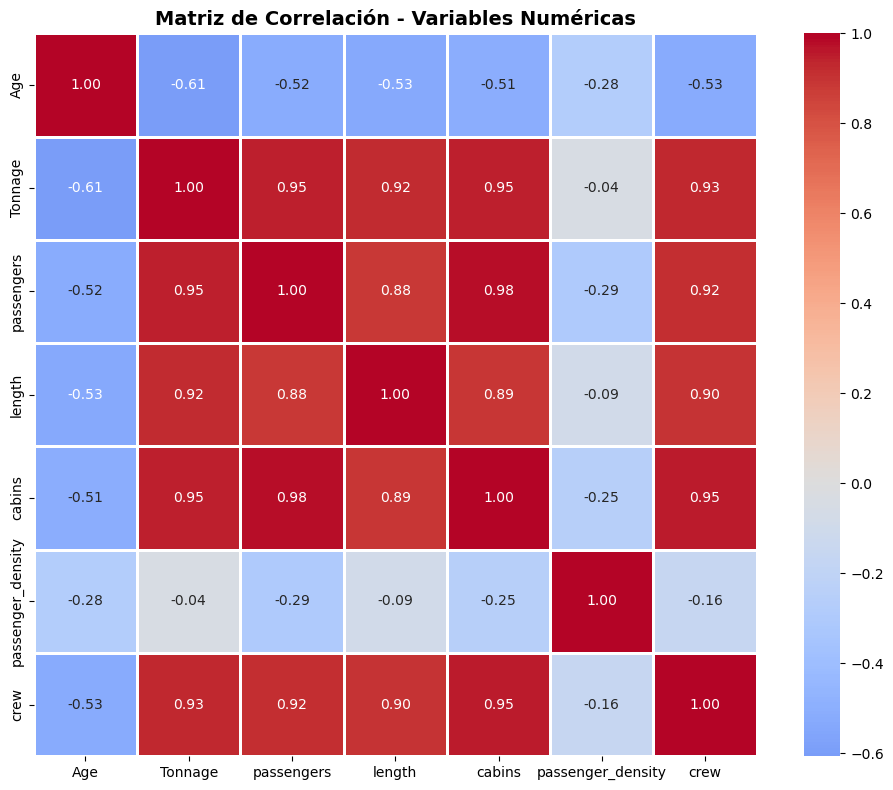

In [11]:
# Heatmap de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()

In [12]:
# Identificar multicolinealidad (correlaciones altas entre predictores)
print("\nAnálisis de Multicolinealidad:")
print("Pares de variables con correlación > 0.9:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            print(f"  - {correlation_matrix.columns[i]} vs {correlation_matrix.columns[j]}: "
                  f"{correlation_matrix.iloc[i, j]:.3f}")


Análisis de Multicolinealidad:
Pares de variables con correlación > 0.9:
  - Tonnage vs passengers: 0.945
  - Tonnage vs length: 0.922
  - Tonnage vs cabins: 0.949
  - Tonnage vs crew: 0.928
  - passengers vs cabins: 0.976
  - passengers vs crew: 0.915
  - cabins vs crew: 0.951


## Gráficas útiles

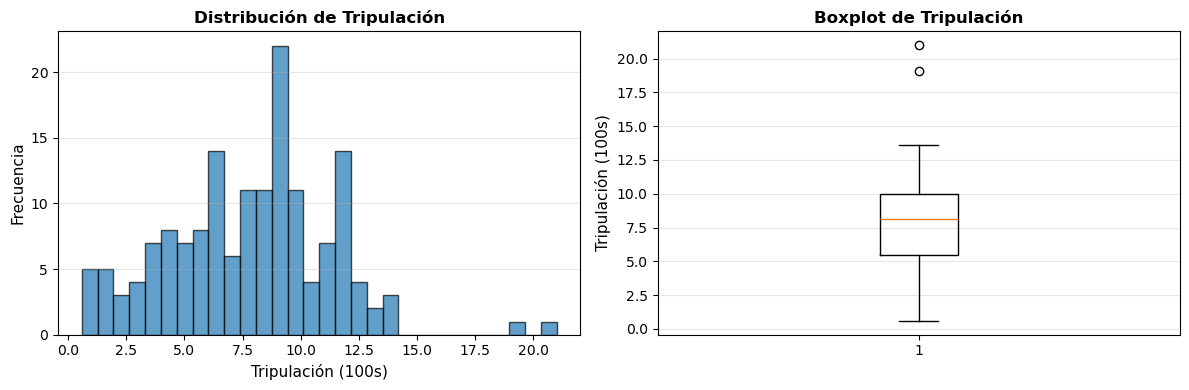

In [13]:
# Distribución de la variable objetivo
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(crew_pandas['crew'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Tripulación (100s)', fontsize=11)
plt.ylabel('Frecuencia', fontsize=11)
plt.title('Distribución de Tripulación', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(crew_pandas['crew'], vert=True)
plt.ylabel('Tripulación (100s)', fontsize=11)
plt.title('Boxplot de Tripulación', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()

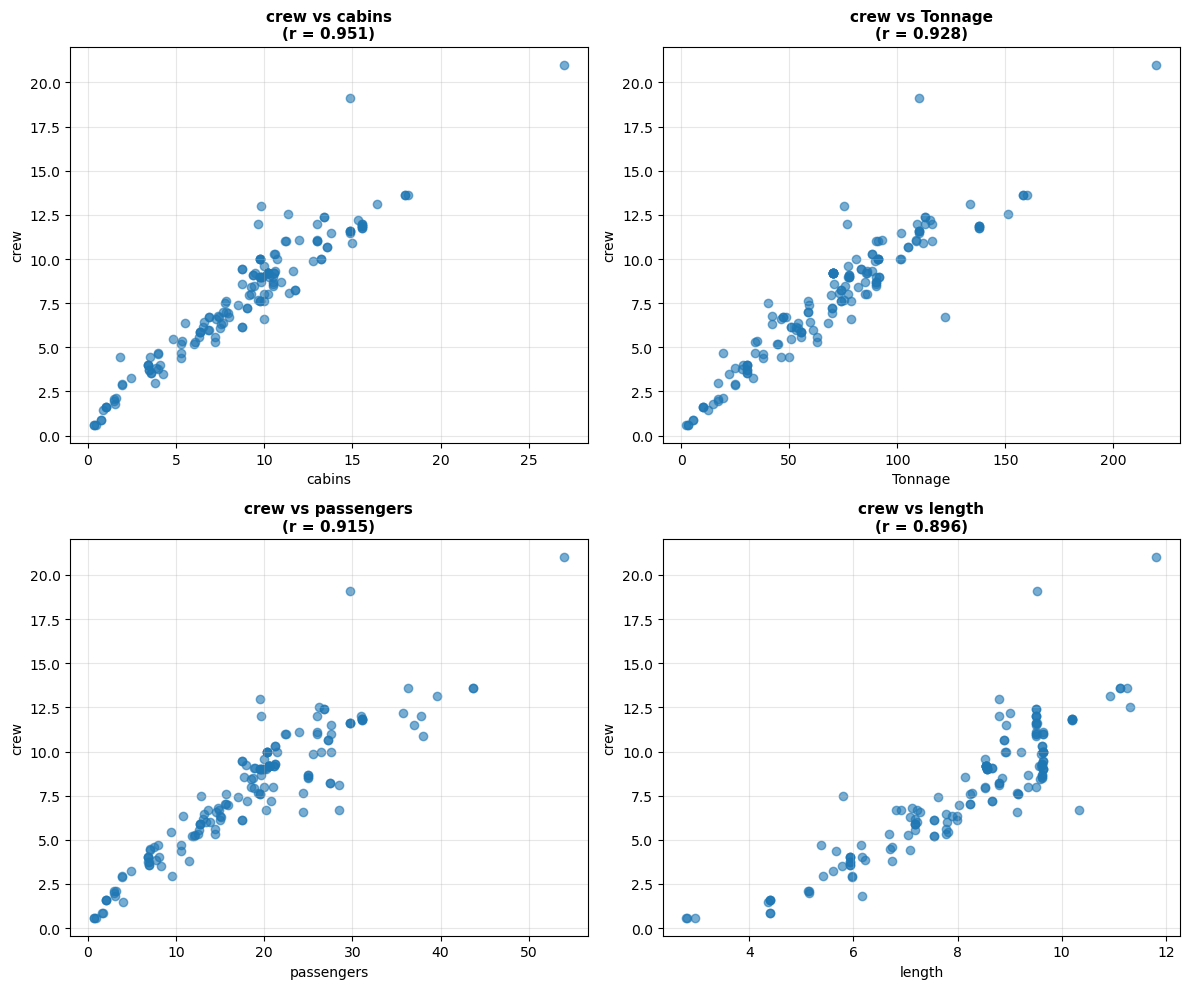

In [14]:
# Scatterplots de las variables más correlacionadas con crew
top_features = crew_correlations.drop('crew').head(4).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for idx, feature in enumerate(top_features):
    row = idx // 2
    col = idx % 2
    axes[row, col].scatter(df_pandas[feature], df_pandas['crew'], alpha=0.6)
    axes[row, col].set_xlabel(feature, fontsize=10)
    axes[row, col].set_ylabel('crew', fontsize=10)
    axes[row, col].set_title(f'crew vs {feature}\n(r = {crew_correlations[feature]:.3f})',
                              fontsize=11, fontweight='bold')
    axes[row, col].grid(alpha=0.3)

plt.tight_layout()

In [19]:
print("\nANÁLISIS DE CRUISE_LINE")
print("-" * 80)

# Contar líneas de cruceros
cruise_counts = df_hyundai.groupBy("Cruise_line").count().orderBy(col("count").desc())
print("\nDistribución de Líneas de Cruceros:")
cruise_counts.show(20)

num_cruise_lines = cruise_counts.count()
print(f"\nTotal de líneas de cruceros diferentes: {num_cruise_lines}")


ANÁLISIS DE CRUISE_LINE
--------------------------------------------------------------------------------

Distribución de Líneas de Cruceros:
+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|  Royal_Caribbean|   23|
|         Carnival|   22|
|         Princess|   17|
| Holland_American|   14|
|        Norwegian|   13|
|            Costa|   11|
|        Celebrity|   10|
|              MSC|    8|
|              P&O|    6|
|             Star|    6|
|Regent_Seven_Seas|    5|
|        Silversea|    4|
|           Cunard|    3|
|         Seabourn|    3|
|         Windstar|    3|
|          Oceania|    3|
|          Crystal|    2|
|           Disney|    2|
|          Azamara|    2|
|           Orient|    1|
+-----------------+-----+


Total de líneas de cruceros diferentes: 20


In [21]:
print("\nEstadísticas de Tripulación por Línea de Cruceros:")
crew_by_cruise = df_hyundai.groupBy("Cruise_line").agg(
    count("crew").alias("num_barcos"),
    mean("crew").alias("promedio_crew"),
    spark_min("crew").alias("min_crew"),
    spark_max("crew").alias("max_crew")
).orderBy(col("promedio_crew").desc())
crew_by_cruise.show(10)


Estadísticas de Tripulación por Línea de Cruceros:
+---------------+----------+------------------+--------+--------+
|    Cruise_line|num_barcos|     promedio_crew|min_crew|max_crew|
+---------------+----------+------------------+--------+--------+
|         Cunard|         3|10.246666666666668|     9.0|   12.53|
|       Carnival|        22| 10.13590909090909|     6.6|    19.1|
|Royal_Caribbean|        23|10.016521739130434|     6.6|    21.0|
|         Disney|         2|              9.45|    9.45|    9.45|
|       Princess|        17|  9.32235294117647|    3.73|   12.38|
|            P&O|         6| 8.588333333333333|     5.2|    12.2|
|      Norwegian|        13| 8.087692307692308|     3.8|    13.0|
|      Celebrity|        10|             8.072|     0.6|    9.99|
|          Costa|        11|               7.7|    3.85|    10.9|
|            MSC|         8|              7.54|    2.97|   13.13|
+---------------+----------+------------------+--------+--------+
only showing top 10 rows

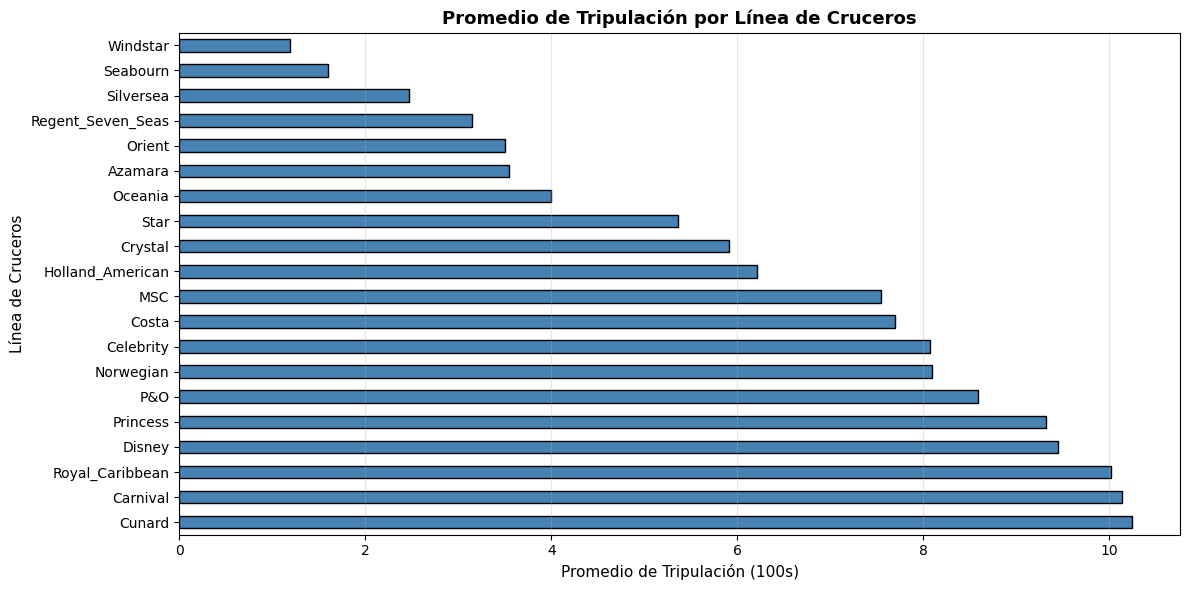

In [22]:
# Visualización
cruise_crew_pandas = df_hyundai.select("Cruise_line", "crew").toPandas()
cruise_crew_avg = cruise_crew_pandas.groupby("Cruise_line")["crew"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
cruise_crew_avg.plot(kind='barh', color='steelblue', edgecolor='black')
plt.xlabel('Promedio de Tripulación (100s)', fontsize=11)
plt.ylabel('Línea de Cruceros', fontsize=11)
plt.title('Promedio de Tripulación por Línea de Cruceros', fontsize=13, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

In [23]:
print("\nCODIFICACIÓN DE CRUISE_LINE")
print("-" * 80)

# Opción 1: StringIndexer (convierte a índices numéricos)
indexer = StringIndexer(inputCol="Cruise_line", outputCol="Cruise_line_index")
df_indexed = indexer.fit(df_hyundai).transform(df_hyundai)

print("\nStringIndexer aplicado:")
df_indexed.select("Cruise_line", "Cruise_line_index").distinct().orderBy("Cruise_line_index").show(10)


CODIFICACIÓN DE CRUISE_LINE
--------------------------------------------------------------------------------

StringIndexer aplicado:
+----------------+-----------------+
|     Cruise_line|Cruise_line_index|
+----------------+-----------------+
| Royal_Caribbean|              0.0|
|        Carnival|              1.0|
|        Princess|              2.0|
|Holland_American|              3.0|
|       Norwegian|              4.0|
|           Costa|              5.0|
|       Celebrity|              6.0|
|             MSC|              7.0|
|             P&O|              8.0|
|            Star|              9.0|
+----------------+-----------------+
only showing top 10 rows



In [24]:
# Opción 2: OneHotEncoder (crea variables dummy)
encoder = OneHotEncoder(inputCols=["Cruise_line_index"],
                        outputCols=["Cruise_line_encoded"])
df_encoded = encoder.fit(df_indexed).transform(df_indexed)

print("\nOneHotEncoder aplicado (vector denso):")
print("✓ Variable 'Cruise_line_encoded' creada (vector sparse)")

# Mostrar resultado
df_encoded.select("Cruise_line", "Cruise_line_index", "Cruise_line_encoded").show(5, truncate=False)


OneHotEncoder aplicado (vector denso):
✓ Variable 'Cruise_line_encoded' creada (vector sparse)
+-----------+-----------------+-------------------+
|Cruise_line|Cruise_line_index|Cruise_line_encoded|
+-----------+-----------------+-------------------+
|Azamara    |16.0             |(19,[16],[1.0])    |
|Azamara    |16.0             |(19,[16],[1.0])    |
|Carnival   |1.0              |(19,[1],[1.0])     |
|Carnival   |1.0              |(19,[1],[1.0])     |
|Carnival   |1.0              |(19,[1],[1.0])     |
+-----------+-----------------+-------------------+
only showing top 5 rows



## Preparación final de los datos

In [25]:
# Versión 1: Con OneHotEncoding de Cruise_line
feature_cols_v1 = ["Age", "Tonnage", "passengers", "length", "cabins",
                   "passenger_density", "Cruise_line_encoded"]

assembler_v1 = VectorAssembler(inputCols=feature_cols_v1, outputCol="features")
df_final_v1 = assembler_v1.transform(df_encoded)

print("\nDataFrame VERSIÓN 1 (con todas las features + OneHotEncoding):")
df_final_v1.select("features", "crew").show(5, truncate=False)


DataFrame VERSIÓN 1 (con todas las features + OneHotEncoding):
+-----------------------------------------------------------------------+----+
|features                                                               |crew|
+-----------------------------------------------------------------------+----+
|(25,[0,1,2,3,4,5,22],[6.0,30.276999999999997,6.94,5.94,3.55,42.64,1.0])|3.55|
|(25,[0,1,2,3,4,5,22],[6.0,30.276999999999997,6.94,5.94,3.55,42.64,1.0])|3.55|
|(25,[0,1,2,3,4,5,7],[26.0,47.262,14.86,7.22,7.43,31.8,1.0])            |6.7 |
|(25,[0,1,2,3,4,5,7],[11.0,110.0,29.74,9.53,14.88,36.99,1.0])           |19.1|
|(25,[0,1,2,3,4,5,7],[17.0,101.353,26.42,8.92,13.21,38.36,1.0])         |10.0|
+-----------------------------------------------------------------------+----+
only showing top 5 rows



In [26]:
# Versión 2: Solo con features recomendadas
feature_cols_v2 = ["Tonnage", "cabins", "passenger_density", "Cruise_line_encoded"]

assembler_v2 = VectorAssembler(inputCols=feature_cols_v2, outputCol="features")
df_final_v2 = assembler_v2.transform(df_encoded)

print("\nDataFrame VERSIÓN 2 (features recomendadas + OneHotEncoding):")
df_final_v2.select("features", "crew").show(5, truncate=False)


DataFrame VERSIÓN 2 (features recomendadas + OneHotEncoding):
+---------------------------------------------------+----+
|features                                           |crew|
+---------------------------------------------------+----+
|(22,[0,1,2,19],[30.276999999999997,3.55,42.64,1.0])|3.55|
|(22,[0,1,2,19],[30.276999999999997,3.55,42.64,1.0])|3.55|
|(22,[0,1,2,4],[47.262,7.43,31.8,1.0])              |6.7 |
|(22,[0,1,2,4],[110.0,14.88,36.99,1.0])             |19.1|
|(22,[0,1,2,4],[101.353,13.21,38.36,1.0])           |10.0|
+---------------------------------------------------+----+
only showing top 5 rows



In [27]:
# Versión 3: Sin OneHotEncoding, solo con índice numérico
feature_cols_v3 = ["Tonnage", "cabins", "passenger_density", "Cruise_line_index"]

assembler_v3 = VectorAssembler(inputCols=feature_cols_v3, outputCol="features")
df_final_v3 = assembler_v3.transform(df_indexed)

print("\nDataFrame VERSIÓN 3 (features recomendadas + StringIndexer):")
df_final_v3.select("features", "crew").show(5, truncate=False)


DataFrame VERSIÓN 3 (features recomendadas + StringIndexer):
+------------------------------------+----+
|features                            |crew|
+------------------------------------+----+
|[30.276999999999997,3.55,42.64,16.0]|3.55|
|[30.276999999999997,3.55,42.64,16.0]|3.55|
|[47.262,7.43,31.8,1.0]              |6.7 |
|[110.0,14.88,36.99,1.0]             |19.1|
|[101.353,13.21,38.36,1.0]           |10.0|
+------------------------------------+----+
only showing top 5 rows



## Entrenamiento del Modelo de Regresión Lineal

In [28]:
from pyspark.ml.regression import LinearRegression


### Paso 1: Dividir los datos en entrenamiento y prueba
 
Vamos a dividir nuestros datos en dos grupos:
- **80% para entrenamiento**: El modelo aprende de estos datos
- **20% para prueba**: Usamos estos datos para ver qué tan bien funciona el modelo con datos nuevos

Es como estudiar para un examen: estudias con unos ejercicios (entrenamiento) y luego te evalúan con ejercicios nuevos (prueba) para ver si realmente aprendiste.


In [29]:
# VERSIÓN 1: Todas las características + OneHotEncoding
print("=" * 80)
print("VERSIÓN 1: Todas las características")
print("=" * 80)

train_v1, test_v1 = df_final_v1.randomSplit([0.8, 0.2], seed=42)

print(f"Datos de entrenamiento: {train_v1.count()} barcos")
print(f"Datos de prueba: {test_v1.count()} barcos")


VERSIÓN 1: Todas las características
Datos de entrenamiento: 133 barcos
Datos de prueba: 25 barcos


In [30]:
# VERSIÓN 2: Características recomendadas + OneHotEncoding
print("\n" + "=" * 80)
print("VERSIÓN 2: Características recomendadas (Tonnage, cabins, passenger_density, Cruise_line)")
print("=" * 80)

train_v2, test_v2 = df_final_v2.randomSplit([0.8, 0.2], seed=42)

print(f"Datos de entrenamiento: {train_v2.count()} barcos")
print(f"Datos de prueba: {test_v2.count()} barcos")



VERSIÓN 2: Características recomendadas (Tonnage, cabins, passenger_density, Cruise_line)
Datos de entrenamiento: 133 barcos
Datos de prueba: 25 barcos


In [31]:
# VERSIÓN 3: Características recomendadas + StringIndexer
print("\n" + "=" * 80)
print("VERSIÓN 3: Características recomendadas con StringIndexer")
print("=" * 80)

train_v3, test_v3 = df_final_v3.randomSplit([0.8, 0.2], seed=42)

print(f"Datos de entrenamiento: {train_v3.count()} barcos")
print(f"Datos de prueba: {test_v3.count()} barcos")



VERSIÓN 3: Características recomendadas con StringIndexer
Datos de entrenamiento: 133 barcos
Datos de prueba: 25 barcos


### Paso 2: Entrenar los modelos
 
Ahora vamos a crear y entrenar un modelo de regresión lineal para cada versión.
El modelo busca encontrar la mejor "fórmula matemática" que relacione las características del barco (tamaño, cabinas, etc.) con el número de tripulantes necesarios.

Es como encontrar la receta perfecta: el modelo aprende qué "ingredientes" (características) y en qué cantidades se necesitan para obtener el "platillo" correcto (número de tripulantes).


In [33]:
# Entrenando VERSIÓN 1
print("\nEntrenando Modelo Versión 1...")
modelo_v1 = LinearRegression(featuresCol='features', labelCol='crew')
modelo_entrenado_v1 = modelo_v1.fit(train_v1)
print("Modelo Versión 1 entrenado exitosamente!")



Entrenando Modelo Versión 1...
Modelo Versión 1 entrenado exitosamente!


In [34]:
# Entrenando VERSIÓN 2
print("\nEntrenando Modelo Versión 2...")
modelo_v2 = LinearRegression(featuresCol='features', labelCol='crew')
modelo_entrenado_v2 = modelo_v2.fit(train_v2)
print("Modelo Versión 2 entrenado exitosamente!")



Entrenando Modelo Versión 2...
Modelo Versión 2 entrenado exitosamente!


In [35]:
# Entrenando VERSIÓN 3
print("\nEntrenando Modelo Versión 3...")
modelo_v3 = LinearRegression(featuresCol='features', labelCol='crew')
modelo_entrenado_v3 = modelo_v3.fit(train_v3)
print("Modelo Versión 3 entrenado exitosamente!")



Entrenando Modelo Versión 3...
Modelo Versión 3 entrenado exitosamente!


## Evaluación del Modelo de Regresión Lineal

Resumen: 
Para saber qué tan bien funciona nuestro modelo, usamos 3 métricas principales:
- **R² (R-cuadrado)**: Va de 0 a 1. Mientras más cerca de 1, mejor. 
Nos dice qué porcentaje de la variación en tripulación puede explicar el modelo.
Ejemplo: R² = 0.95 significa que el modelo explica el 95% de por qué los barcos tienen diferente tripulación.

- **RMSE (Error Cuadrático Medio)**: El error promedio de las predicciones. 
Mientras más bajo, mejor. Se mide en las mismas unidades (100s de tripulantes).
Ejemplo: RMSE = 0.5 significa que en promedio nos equivocamos por 0.5 (o sea, 50 tripulantes).
 
- **MAE (Error Absoluto Medio)**: Similar al RMSE pero más fácil de interpretar.
Es el promedio de qué tan lejos están nuestras predicciones de la realidad.
Ejemplo: MAE = 0.4 significa que en promedio nos equivocamos por 40 tripulantes.



In [41]:
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd

### Evaluando los 3 modelos

In [42]:
# Crear evaluadores para cada métrica
evaluador_r2 = RegressionEvaluator(labelCol="crew", predictionCol="prediction", metricName="r2")
evaluador_rmse = RegressionEvaluator(labelCol="crew", predictionCol="prediction", metricName="rmse")
evaluador_mae = RegressionEvaluator(labelCol="crew", predictionCol="prediction", metricName="mae")


#### Evaluación Modelo Versión 1 (Todas las características)

In [43]:
print("=" * 80)
print("EVALUACIÓN MODELO VERSIÓN 1: Todas las características")
print("=" * 80)

r2_v1 = evaluador_r2.evaluate(predicciones_v1)
rmse_v1 = evaluador_rmse.evaluate(predicciones_v1)
mae_v1 = evaluador_mae.evaluate(predicciones_v1)

print(f"\n Resultados:")
print(f"   R² (R-cuadrado):           {r2_v1:.4f} ({r2_v1*100:.2f}% de varianza explicada)")
print(f"   RMSE (Error cuadrático):   {rmse_v1:.4f} (equivalente a {rmse_v1*100:.1f} tripulantes)")
print(f"   MAE (Error absoluto):      {mae_v1:.4f} (equivalente a {mae_v1*100:.1f} tripulantes)")


EVALUACIÓN MODELO VERSIÓN 1: Todas las características

 Resultados:
   R² (R-cuadrado):           0.9725 (97.25% de varianza explicada)
   RMSE (Error cuadrático):   0.5283 (equivalente a 52.8 tripulantes)
   MAE (Error absoluto):      0.3707 (equivalente a 37.1 tripulantes)


#### Evaluación Modelo Versión 2 (Características recomendadas + OneHotEncoding)

In [44]:
print("\n" + "=" * 80)
print("EVALUACIÓN MODELO VERSIÓN 2: Características recomendadas + OneHotEncoding")
print("=" * 80)

r2_v2 = evaluador_r2.evaluate(predicciones_v2)
rmse_v2 = evaluador_rmse.evaluate(predicciones_v2)
mae_v2 = evaluador_mae.evaluate(predicciones_v2)

print(f"\nResultados:")
print(f"   R² (R-cuadrado):           {r2_v2:.4f} ({r2_v2*100:.2f}% de varianza explicada)")
print(f"   RMSE (Error cuadrático):   {rmse_v2:.4f} (equivalente a {rmse_v2*100:.1f} tripulantes)")
print(f"   MAE (Error absoluto):      {mae_v2:.4f} (equivalente a {mae_v2*100:.1f} tripulantes)")


EVALUACIÓN MODELO VERSIÓN 2: Características recomendadas + OneHotEncoding

Resultados:
   R² (R-cuadrado):           0.4640 (46.40% de varianza explicada)
   RMSE (Error cuadrático):   2.3313 (equivalente a 233.1 tripulantes)
   MAE (Error absoluto):      0.8327 (equivalente a 83.3 tripulantes)


#### Evaluación Modelo Versión 3 (Características recomendadas + StringIndexer)


In [45]:
print("\n" + "=" * 80)
print("EVALUACIÓN MODELO VERSIÓN 3: Características recomendadas + StringIndexer")
print("=" * 80)

r2_v3 = evaluador_r2.evaluate(predicciones_v3)
rmse_v3 = evaluador_rmse.evaluate(predicciones_v3)
mae_v3 = evaluador_mae.evaluate(predicciones_v3)

print(f"\nResultados:")
print(f"   R² (R-cuadrado):           {r2_v3:.4f} ({r2_v3*100:.2f}% de varianza explicada)")
print(f"   RMSE (Error cuadrático):   {rmse_v3:.4f} (equivalente a {rmse_v3*100:.1f} tripulantes)")
print(f"   MAE (Error absoluto):      {mae_v3:.4f} (equivalente a {mae_v3*100:.1f} tripulantes)")



EVALUACIÓN MODELO VERSIÓN 3: Características recomendadas + StringIndexer

Resultados:
   R² (R-cuadrado):           0.9518 (95.18% de varianza explicada)
   RMSE (Error cuadrático):   0.6991 (equivalente a 69.9 tripulantes)
   MAE (Error absoluto):      0.5593 (equivalente a 55.9 tripulantes)


### Tabla comparativa

In [46]:
resultados = {
    'Modelo': ['Versión 1\n(Todas)', 'Versión 2\n(Optimizada)', 'Versión 3\n(StringIndexer)'],
    'R² Score': [f'{r2_v1:.4f}', f'{r2_v2:.4f}', f'{r2_v3:.4f}'],
    'RMSE': [f'{rmse_v1:.4f}', f'{rmse_v2:.4f}', f'{rmse_v3:.4f}'],
    'MAE': [f'{mae_v1:.4f}', f'{mae_v2:.4f}', f'{mae_v3:.4f}'],
    'Características': ['Age, Tonnage, passengers,\nlength, cabins,\npassenger_density,\nCruise_line (OHE)',
                       'Tonnage, cabins,\npassenger_density,\nCruise_line (OHE)',
                       'Tonnage, cabins,\npassenger_density,\nCruise_line (Index)']
}

df_resultados = pd.DataFrame(resultados)

print("\n" + "=" * 100)
print("TABLA COMPARATIVA DE RENDIMIENTO")
print("=" * 100)
print(df_resultados.to_string(index=False))
print("=" * 100)



TABLA COMPARATIVA DE RENDIMIENTO
                    Modelo R² Score   RMSE    MAE                                                                   Características
        Versión 1\n(Todas)   0.9725 0.5283 0.3707 Age, Tonnage, passengers,\nlength, cabins,\npassenger_density,\nCruise_line (OHE)
   Versión 2\n(Optimizada)   0.4640 2.3313 0.8327                           Tonnage, cabins,\npassenger_density,\nCruise_line (OHE)
Versión 3\n(StringIndexer)   0.9518 0.6991 0.5593                         Tonnage, cabins,\npassenger_density,\nCruise_line (Index)


### Visualización de Comparación

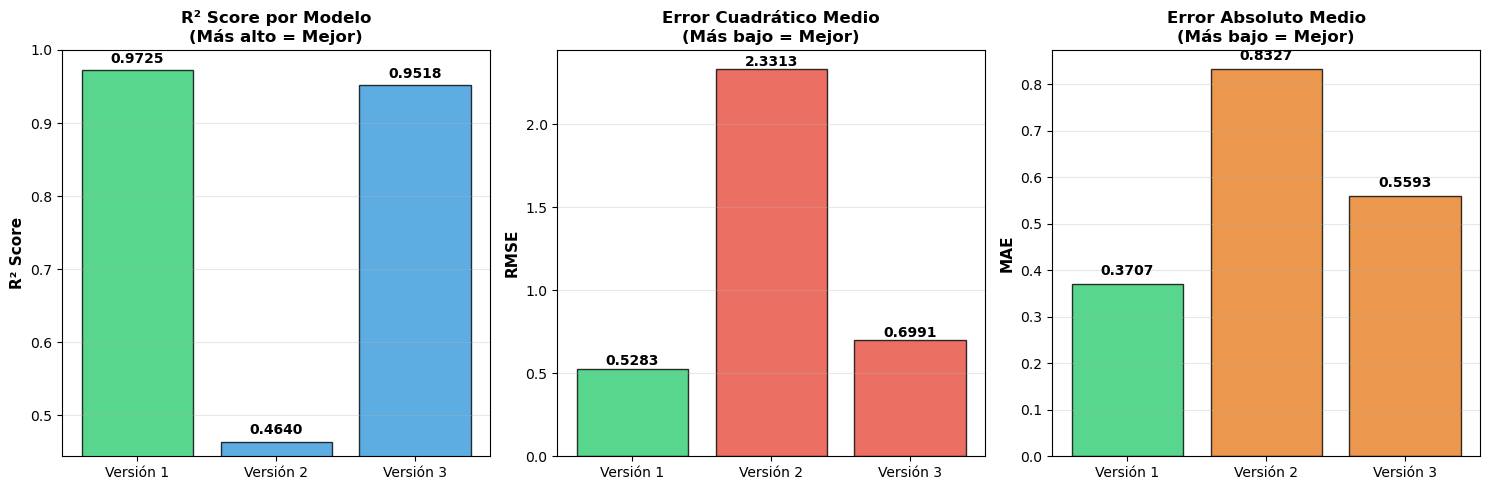

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Preparar datos para visualización
modelos = ['Versión 1', 'Versión 2', 'Versión 3']
r2_scores = [r2_v1, r2_v2, r2_v3]
rmse_scores = [rmse_v1, rmse_v2, rmse_v3]
mae_scores = [mae_v1, mae_v2, mae_v3]

# Crear figura con 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gráfico 1: R² Score
colors_r2 = ['#2ecc71' if r2 == max(r2_scores) else '#3498db' for r2 in r2_scores]
axes[0].bar(modelos, r2_scores, color=colors_r2, edgecolor='black', alpha=0.8)
axes[0].set_ylabel('R² Score', fontsize=11, fontweight='bold')
axes[0].set_title('R² Score por Modelo\n(Más alto = Mejor)', fontsize=12, fontweight='bold')
axes[0].set_ylim([min(r2_scores) - 0.02, 1.0])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(r2_scores):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# Gráfico 2: RMSE
colors_rmse = ['#2ecc71' if rmse == min(rmse_scores) else '#e74c3c' for rmse in rmse_scores]
axes[1].bar(modelos, rmse_scores, color=colors_rmse, edgecolor='black', alpha=0.8)
axes[1].set_ylabel('RMSE', fontsize=11, fontweight='bold')
axes[1].set_title('Error Cuadrático Medio\n(Más bajo = Mejor)', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(rmse_scores):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# Gráfico 3: MAE
colors_mae = ['#2ecc71' if mae == min(mae_scores) else '#e67e22' for mae in mae_scores]
axes[2].bar(modelos, mae_scores, color=colors_mae, edgecolor='black', alpha=0.8)
axes[2].set_ylabel('MAE', fontsize=11, fontweight='bold')
axes[2].set_title('Error Absoluto Medio\n(Más bajo = Mejor)', fontsize=12, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(mae_scores):
    axes[2].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


Podemos observar de los resultados que: 

- Mejor R² Score:    Modelo Versión 1
- Menor RMSE:        Modelo Versión 1
- Menor MAE:         Modelo Versión 1

### Análisis de Predicciones vs Valores Reales

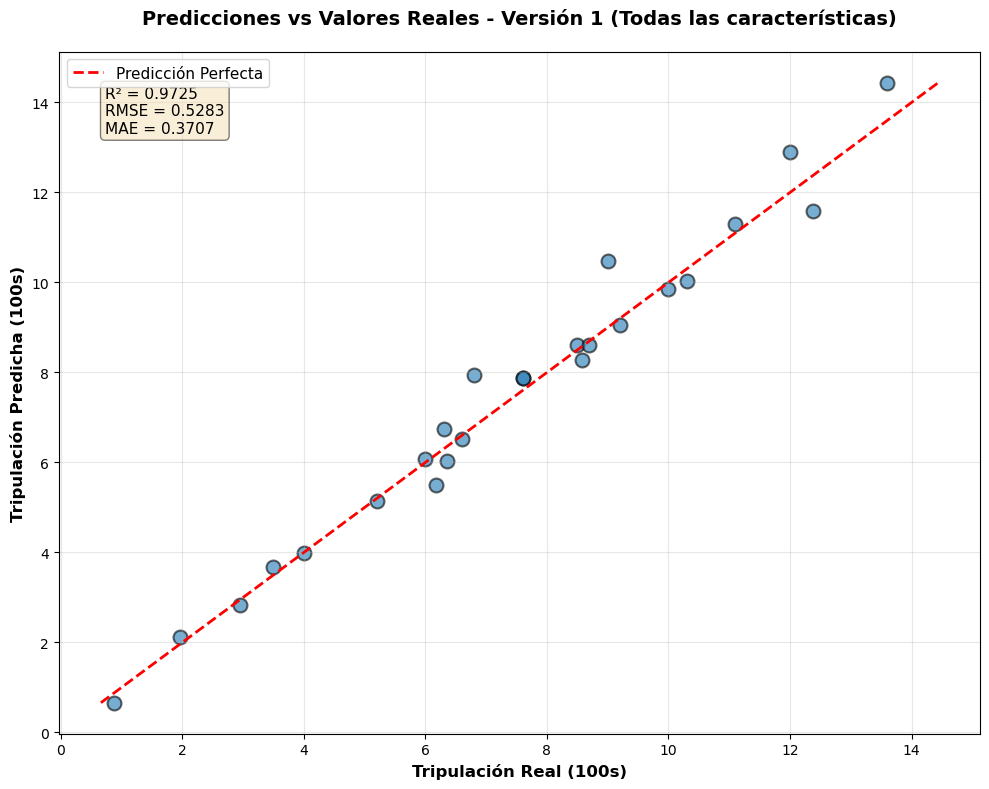

In [52]:
# Convertir a Pandas para visualización
pred_pandas = predicciones_v1.select("crew", "prediction").toPandas()

# Crear gráfico de dispersión
plt.figure(figsize=(10, 8))

plt.scatter(pred_pandas['crew'], pred_pandas['prediction'], 
           alpha=0.6, s=100, edgecolor='black', linewidth=1.5)

# Línea de predicción perfecta
min_val = min(pred_pandas['crew'].min(), pred_pandas['prediction'].min())
max_val = max(pred_pandas['crew'].max(), pred_pandas['prediction'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción Perfecta')

plt.xlabel('Tripulación Real (100s)', fontsize=12, fontweight='bold')
plt.ylabel('Tripulación Predicha (100s)', fontsize=12, fontweight='bold')
plt.title(f'Predicciones vs Valores Reales - {"Versión 1 (Todas las características)"}', 
         fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

plt.text(0.05, 0.95, texto, transform=plt.gca().transAxes,
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### Predicciones con el Data set

In [54]:
print("\n" + "=" * 80)
print("ESCENARIO REAL: Hyundai tiene 3 clientes nuevos que quieren barcos")
print("=" * 80)

# Crear barcos hipotéticos que NO están en tu dataset
from pyspark.sql import Row

barcos_clientes_nuevos = [
    Row(Ship_name="Nuevo Barco Cliente A", 
        Cruise_line="Royal_Caribbean", 
        Age=0,  # Barco nuevo
        Tonnage=175.0, 
        passengers=42.0, 
        length=10.5, 
        cabins=21.0, 
        passenger_density=41.7),
    
    Row(Ship_name="Nuevo Barco Cliente B", 
        Cruise_line="Carnival", 
        Age=0, 
        Tonnage=110.0, 
        passengers=28.0, 
        length=8.5, 
        cabins=14.0, 
        passenger_density=39.3),
]

# Convertir a DataFrame de Spark
df_clientes = spark.createDataFrame(barcos_clientes_nuevos)

print("\nCaracterísticas de los barcos que los clientes quieren construir:")
df_clientes.show(truncate=False)

# Aplicar las mismas transformaciones que usaste para entrenar
df_clientes_indexed = indexer.fit(df_hyundai).transform(df_clientes)
df_clientes_encoded = encoder.fit(df_indexed).transform(df_clientes_indexed)
df_clientes_final = assembler_v1.transform(df_clientes_encoded)

# PREDICCIÓN para estos barcos nuevos
predicciones_clientes = modelo_entrenado_v1.transform(df_clientes_final)

print("\n" + "=" * 80)
print("RECOMENDACIONES DE TRIPULACIÓN PARA LOS CLIENTES:")
print("=" * 80)

for row in predicciones_clientes.select("Ship_name", "Tonnage", "cabins", "prediction").collect():
    tripulantes_reales = int(row['prediction'] * 100)  # Convertir de 100s a número real
    print(f"\n{row['Ship_name']}:")
    print(f"  - Tonelaje: {row['Tonnage']*1000:.0f} toneladas")
    print(f"  - Cabinas: {row['cabins']*100:.0f} cabinas")
    print(f"  TRIPULACIÓN RECOMENDADA: ~{tripulantes_reales} tripulantes")


ESCENARIO REAL: Hyundai tiene 3 clientes nuevos que quieren barcos

Características de los barcos que los clientes quieren construir:
+---------------------+---------------+---+-------+----------+------+------+-----------------+
|Ship_name            |Cruise_line    |Age|Tonnage|passengers|length|cabins|passenger_density|
+---------------------+---------------+---+-------+----------+------+------+-----------------+
|Nuevo Barco Cliente A|Royal_Caribbean|0  |175.0  |42.0      |10.5  |21.0  |41.7             |
|Nuevo Barco Cliente B|Carnival       |0  |110.0  |28.0      |8.5   |14.0  |39.3             |
+---------------------+---------------+---+-------+----------+------+------+-----------------+


RECOMENDACIONES DE TRIPULACIÓN PARA LOS CLIENTES:

Nuevo Barco Cliente A:
  - Tonelaje: 175000 toneladas
  - Cabinas: 2100 cabinas
  TRIPULACIÓN RECOMENDADA: ~1589 tripulantes

Nuevo Barco Cliente B:
  - Tonelaje: 110000 toneladas
  - Cabinas: 1400 cabinas
  TRIPULACIÓN RECOMENDADA: ~1161 tri